# Loading Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from music21 import converter, instrument, note, chord
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from concurrent.futures import ThreadPoolExecutor
import logging

warnings.filterwarnings('ignore')


# Functions

In [26]:
# # Function to parse MIDI files and convert them to piano roll representation
# def midi_to_piano_roll(file_path):
#     midi = converter.parse(file_path)
#     parts = instrument.partitionByInstrument(midi)
#     notes = []
#     if parts:  # file has instrument parts
#         for part in parts.parts:
#             if 'Piano' in str(part):  # look for piano part
#                 notes_to_parse = part.recurse()
#                 for element in notes_to_parse:
#                     if isinstance(element, note.Note):
#                         notes.append(str(element.pitch))
#                     elif isinstance(element, chord.Chord):
#                         notes.append('.'.join(str(n) for n in element.normalOrder))
#     else:  # file has notes in flat structure
#         notes_to_parse = midi.flat.notes
#         for element in notes_to_parse:
#             if isinstance(element, note.Note):
#                 notes.append(str(element.pitch))
#             elif isinstance(element, chord.Chord):
#                 notes.append('.'.join(str(n) for n in element.normalOrder))
#     return notes


In [2]:
# Function to parse MIDI files and convert them to piano roll representation
def midi_to_piano_roll(file_path):
    try:
        midi = converter.parse(file_path)
        parts = instrument.partitionByInstrument(midi)
        notes = []
        
        if parts:  # file has instrument parts
            for part in parts.parts:
                if 'Piano' in str(part):  # look for piano part
                    notes_to_parse = part.recurse()
                    for element in notes_to_parse:
                        if isinstance(element, note.Note):
                            notes.append(str(element.pitch))
                        elif isinstance(element, chord.Chord):
                            notes.append('.'.join(str(n) for n in element.normalOrder))
        else:  # file has notes in flat structure
            notes_to_parse = midi.flat.notes
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
        
        return notes
    
    except Exception as e:
        logging.error(f"Error processing {file_path}: {e}")
        return []

# Loading data with parallel processing

In [5]:
# Function to process a single composer's MIDI files
def process_composer(composer, data_dir):
    midi_files = glob.glob(os.path.join(data_dir, composer, '**', '*.[mM][iI][dD]'), recursive=True)
    notes_list = []
    for file in midi_files:
        notes = midi_to_piano_roll(file)
        notes_list.append(notes)
    return composer, notes_list


In [6]:
# Load and preprocess all MIDI files using parallel processing
def load_data_parallel(data_dir):
    composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
    all_notes = []
    labels = []
    
    with ThreadPoolExecutor() as executor:
        results = executor.map(process_composer, composers, [data_dir]*len(composers))
    
    for composer, notes_list in results:
        all_notes.extend(notes_list)
        labels.extend([composer] * len(notes_list))
    
    return all_notes, labels


In [7]:

# Define directories and parameters
extraction_dir = './data/midiclassics'
data_dir = extraction_dir

# Load and preprocess data using parallel processing
all_notes, labels = load_data_parallel(data_dir)

#print(all_notes)

ERROR:root:Error processing ./data/midiclassics\Beethoven\op051 3 Rondos.mid: 1957352831392
ERROR:root:Error processing ./data/midiclassics\Bach\Bwv0564 Toccata Adagio and Fugue.MID: 1957520268496
ERROR:root:Error processing ./data/midiclassics\Beethoven\Overture ''Fidelio'' op72b.mid: 1957485812800
ERROR:root:Error processing ./data/midiclassics\Beethoven\Overture ''Inauguration of the House'' op214.mid: 1957534065424
ERROR:root:Error processing ./data/midiclassics\Beethoven\Overture ''King Stephen''.mid: 1957623306368
ERROR:root:Error processing ./data/midiclassics\Mozart\K573 9 Variations for Piano Uber Duport.mid: 1957738006128
ERROR:root:Error processing ./data/midiclassics\Beethoven\Overture ''Leonore'' n3 op72.mid: 1957484306384
ERROR:root:Error processing ./data/midiclassics\Chopin\Sonata op35 n2 .mid: 1957835295712
ERROR:root:Error processing ./data/midiclassics\Mozart\Piano Concertos\Piano Concerto n12 K414 1mov.mid: 1957687483600
ERROR:root:Error processing ./data/midiclassi

# Processing the data

In [8]:
# Convert notes to numeric representation
def prepare_sequences(notes, labels, sequence_length=100):
    pitchnames = sorted(set(item for sublist in notes for item in sublist))
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    
    network_input = []
    network_output = []
    label_list = []
    
    for note_list, label in zip(notes, labels):
        for i in range(0, len(note_list) - sequence_length):
            seq_in = note_list[i:i + sequence_length]
            seq_out = note_list[i + sequence_length]
            network_input.append([note_to_int[char] for char in seq_in])
            network_output.append(note_to_int[seq_out])
            label_list.append(label)
    
    n_patterns = len(network_input)
    
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(len(pitchnames))
    network_output = tf.keras.utils.to_categorical(network_output)
    
    return network_input, network_output, label_list

sequence_length = 100

# Prepare sequences
network_input, network_output, label_list = prepare_sequences(all_notes, labels, sequence_length)

# Encode labels
label_to_int = {label: i for i, label in enumerate(set(label_list))}
encoded_labels = [label_to_int[label] for label in label_list]
encoded_labels = tf.keras.utils.to_categorical(encoded_labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(network_input, encoded_labels, test_size=0.2, random_state=42)


# Data analysis

In [17]:
# Basic Information
print("Number of sequences:", len(network_input))
print("Number of unique labels:", len(set(label_list)))

Number of sequences: 1150011
Number of unique labels: 4


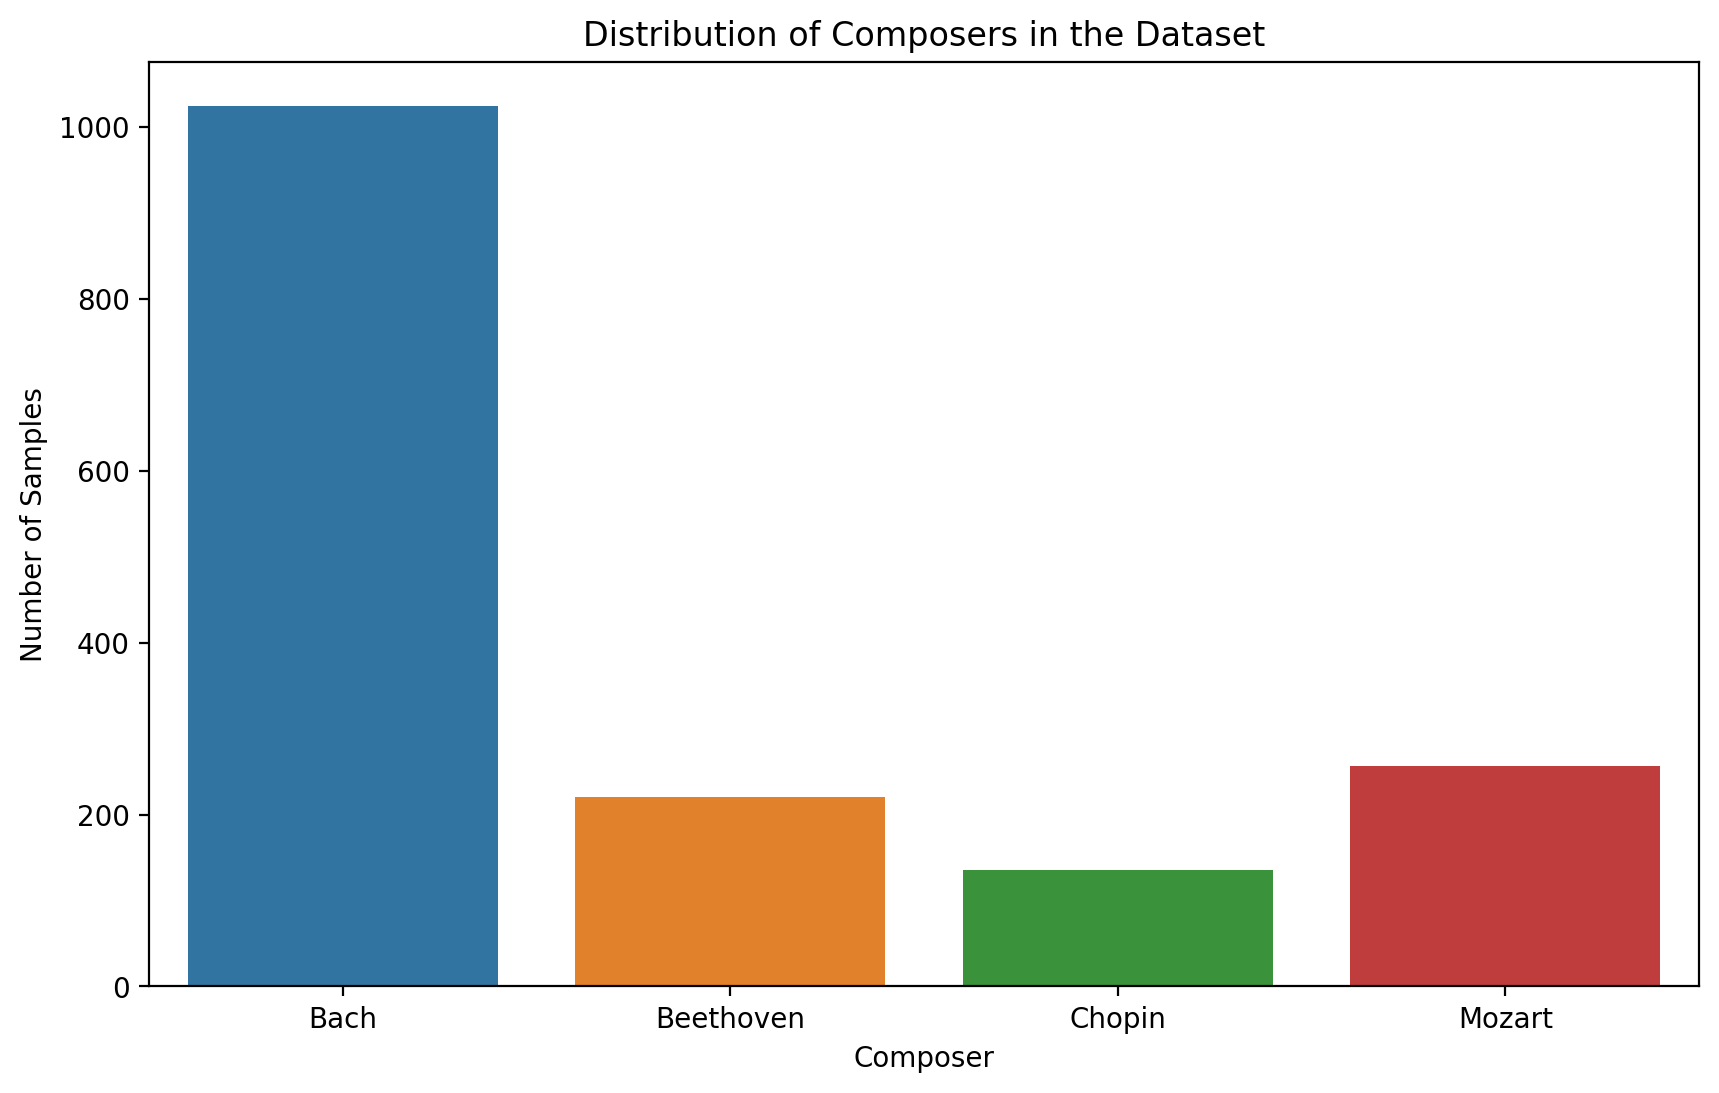

In [25]:
# Extract some basic statistics about the dataset
def dataset_statistics(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    return unique_labels, counts

# Plot the distribution of composers in the dataset
def plot_composer_distribution(unique_labels, counts):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=unique_labels, y=counts)
    plt.title('Distribution of Composers in the Dataset')
    plt.xlabel('Composer')
    plt.ylabel('Number of Samples')
    plt.show()

# Get statistics and plot visualizations
unique_labels, counts = dataset_statistics(labels)

# Plot distribution of composers
plot_composer_distribution(unique_labels, counts)

The graph illustrates the number of MIDI file samples attributed to each composer within the dataset. Bach is prominently represented, with approximately 1000 samples, significantly outnumbering the other composers. Beethoven and Mozart each have around 250 samples, while Chopin has about 125 samples. This notable imbalance suggests that the dataset is heavily skewed towards Bach, which could lead to a bias in any trained models favoring Bach's musical patterns. Addressing this imbalance through techniques such as data augmentation, class weighting, or resampling may be necessary to ensure a more balanced and fair analysis or model training.


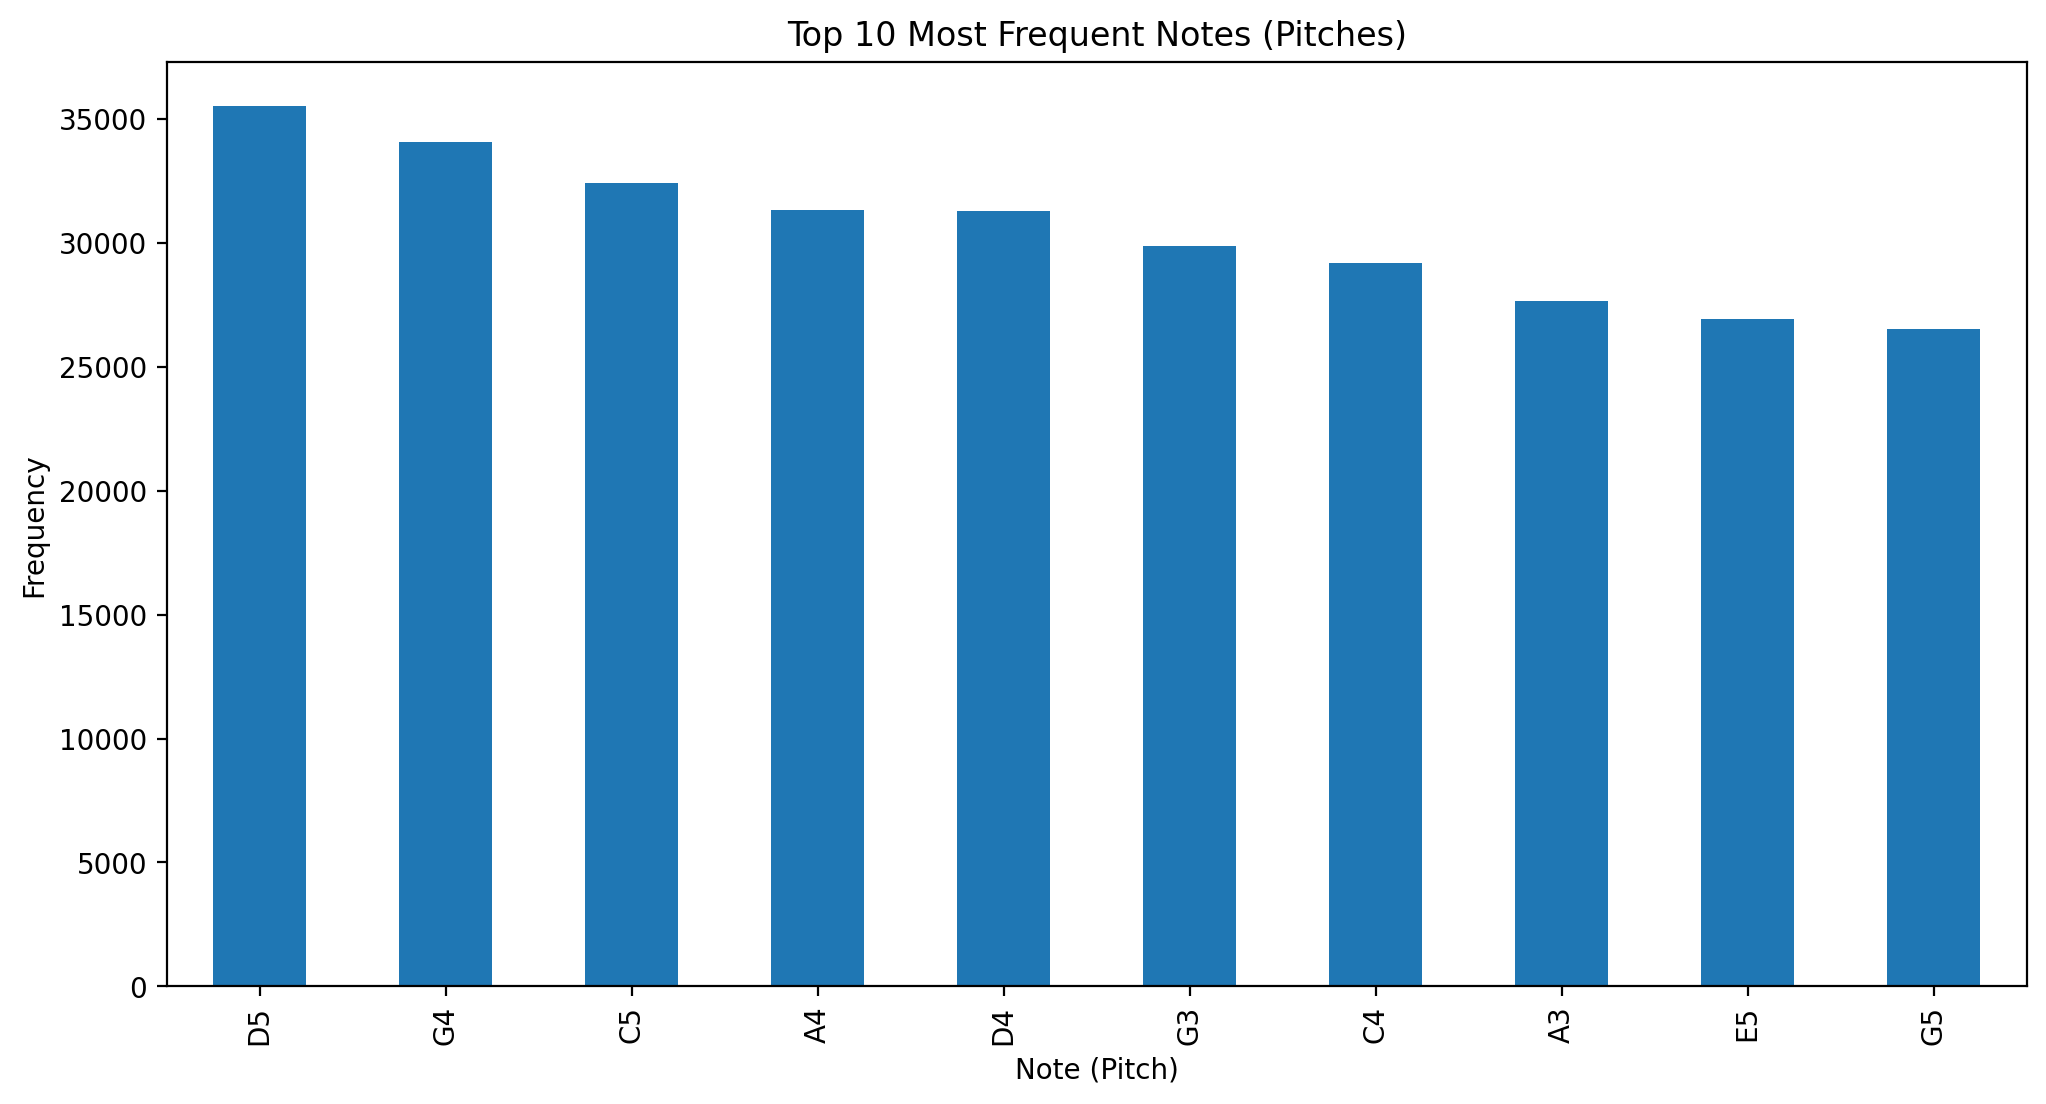

In [23]:
# Distribution of Notes (Pitches) - Top 10
all_pitches = [note for sublist in all_notes for note in sublist]
pitch_counts = pd.Series(all_pitches).value_counts()

# Get the top 10 most frequent pitches
top_pitches = pitch_counts.head(10)

plt.figure(figsize=(12, 6))
top_pitches.plot(kind='bar')
plt.title("Top 10 Most Frequent Notes (Pitches)")
plt.xlabel("Note (Pitch)")
plt.ylabel("Frequency")
plt.show()

The graph illustrates the ten most frequently occurring musical notes in the dataset. The note D5 appears most frequently, with over 35,000 occurrences. Other common notes include G4, C5, A4, and D4, each with substantial representation. This distribution highlights the predominant use of these pitches across the compositions in the dataset.


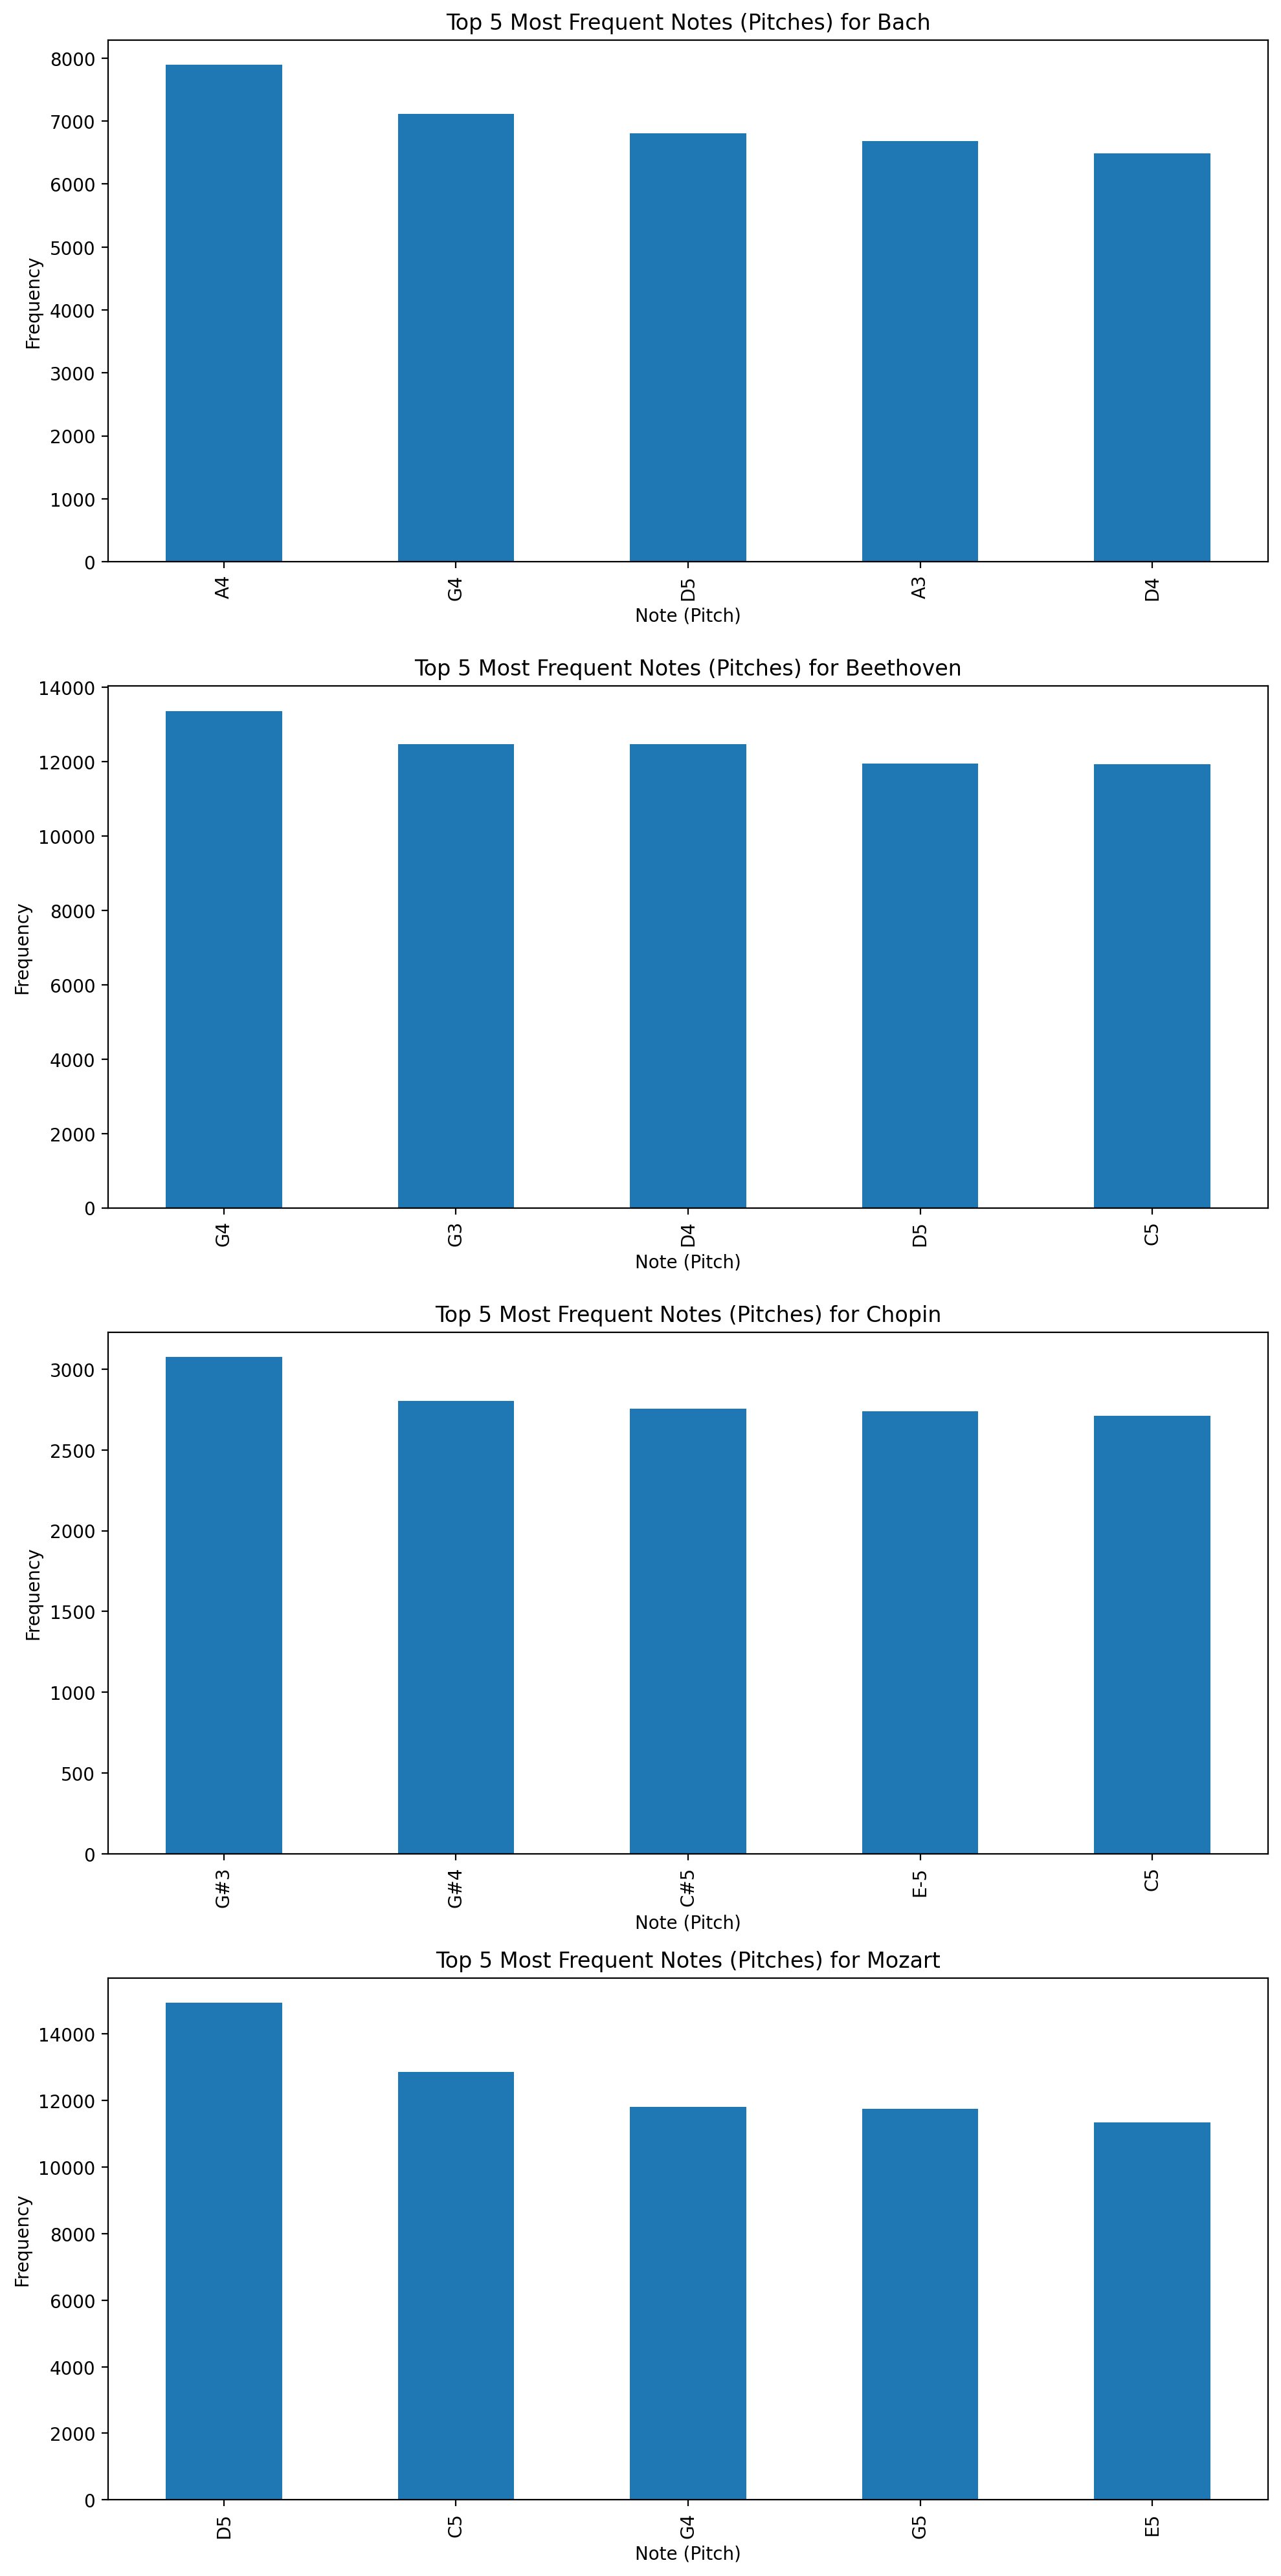

In [27]:
# Function to plot top 5 pitches for each composer as subplots
def plot_top_pitches_by_composer(notes, labels):
    composer_notes = {}
    
    # Aggregate notes by composer
    for note_list, label in zip(notes, labels):
        if label not in composer_notes:
            composer_notes[label] = []
        composer_notes[label].extend(note_list)
    
    composers = list(composer_notes.keys())
    num_composers = len(composers)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=num_composers, ncols=1, figsize=(10, 5 * num_composers))
    
    if num_composers == 1:
        axes = [axes]  # Ensure axes is iterable if there is only one subplot
    
    # Plot top 5 pitches for each composer
    for ax, composer in zip(axes, composers):
        notes = composer_notes[composer]
        pitch_counts = pd.Series(notes).value_counts()
        top_pitches = pitch_counts.head(5)
        
        top_pitches.plot(kind='bar', ax=ax)
        ax.set_title(f"Top 5 Most Frequent Notes (Pitches) for {composer}")
        ax.set_xlabel("Note (Pitch)")
        ax.set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Call the function with your data
plot_top_pitches_by_composer(all_notes, labels)



The series of graphs titled "Top 5 Most Frequent Notes (Pitches) for [Composer]" illustrate the five most commonly occurring musical notes for each composer in the dataset: Bach, Beethoven, Chopin, and Mozart. For Bach, the most frequent notes are A4, G4, and D5, while Beethoven's compositions predominantly feature G4, G3, and D4. Chopin's top notes are G#3, G#4, and C#5, and Mozart's most common notes include D5, C5, and G4. These graphs provide a detailed breakdown of the note distributions for each composer, correlating with the overall pitch distribution seen in the previous graph. This detailed composer-specific analysis highlights the varying musical styles and note preferences among these composers, showing that while some notes are frequently used across multiple composers, others are more unique to individual styles.


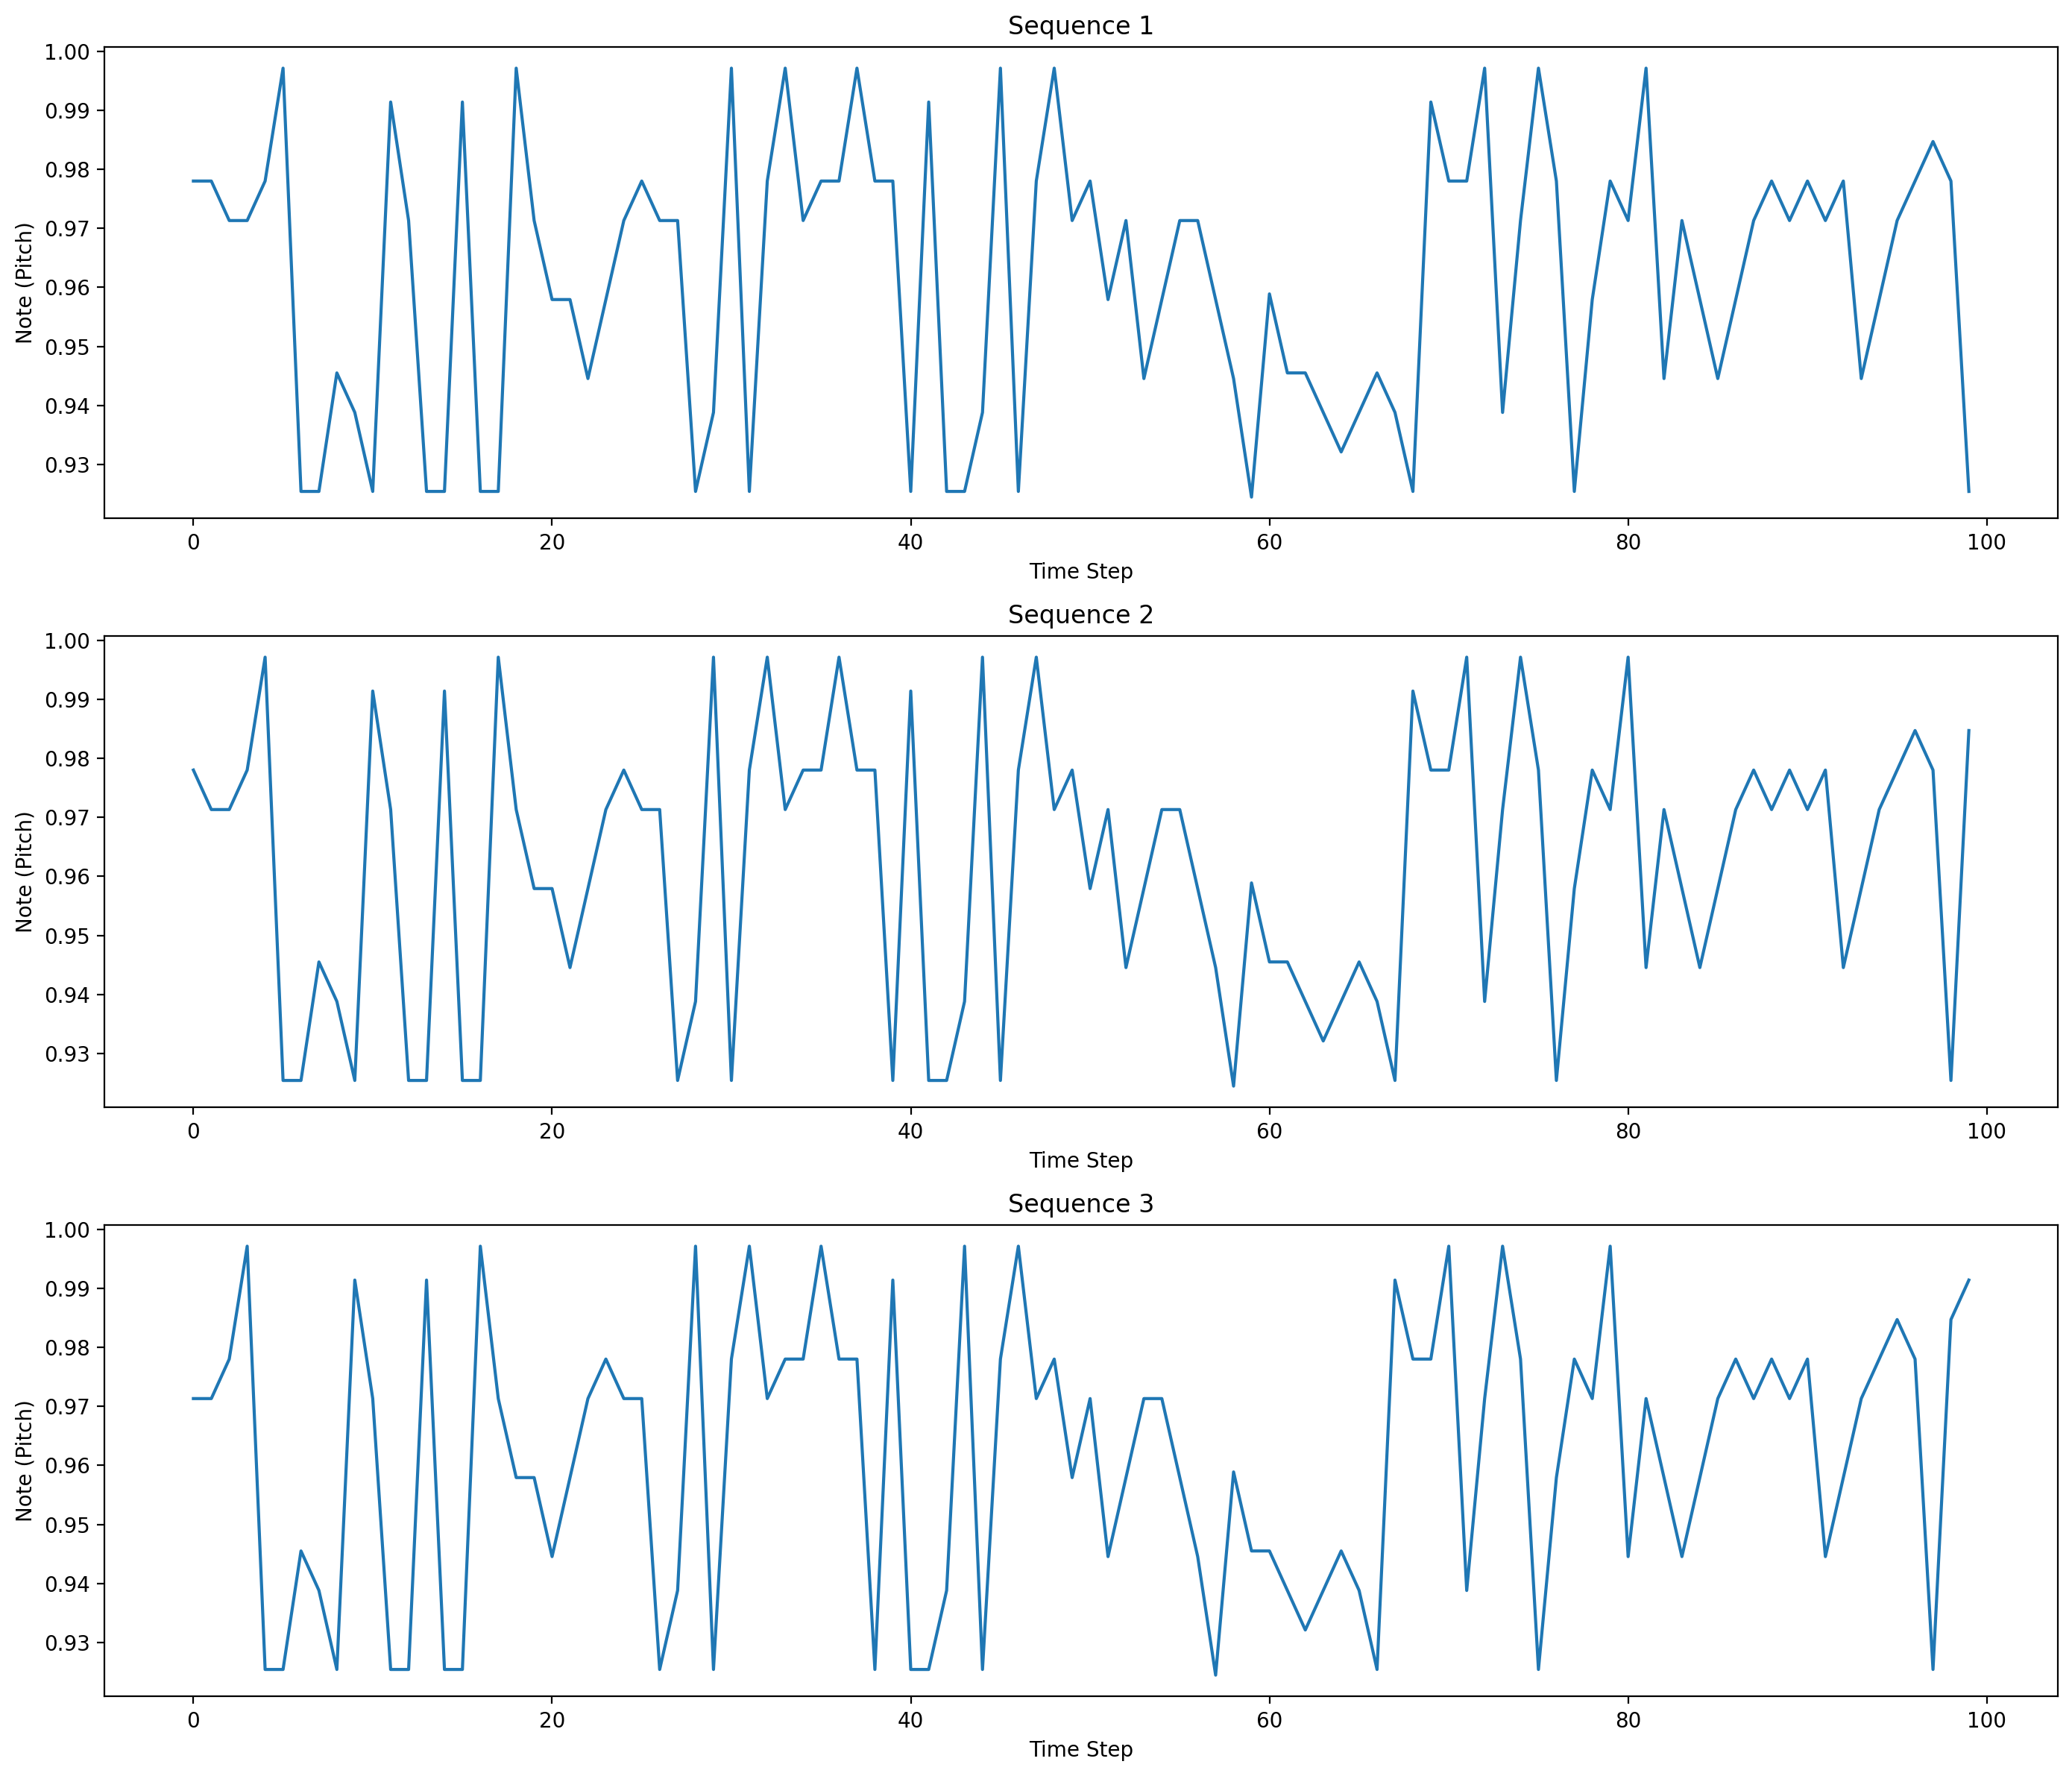

Checking for missing values in sequences...
Missing values: 0


In [30]:
# Function to plot sequences as subplots
def plot_sequences(sequences, num_sequences=3):
    fig, axes = plt.subplots(nrows=num_sequences, ncols=1, figsize=(14, 4 * num_sequences))
    
    if num_sequences == 1:
        axes = [axes]  # Ensure axes is iterable if there is only one subplot
    
    for i, ax in enumerate(axes):
        sequence = sequences[i].flatten()
        ax.plot(sequence)
        ax.set_title(f"Sequence {i + 1}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Note (Pitch)")
    
    plt.tight_layout()
    plt.show()

# Plot a few sequences as subplots
plot_sequences(network_input, num_sequences=3)

# Check for Missing Values
print("Checking for missing values in sequences...")
missing_values = pd.DataFrame(network_input.reshape(-1, sequence_length)).isnull().sum().sum()
print(f"Missing values: {missing_values}")



The graph shows three subplots, each titled "Sequence 1," "Sequence 2," and "Sequence 3," visualizing different sequences of note pitches over time steps. The x-axis represents time steps, and the y-axis represents normalized note pitches. These visualizations help to understand the variation and patterns in the sequences, each visualizing a sample sequence of note pitches over time steps. The x-axis represents time steps, and the y-axis represents normalized note pitches. These sequences are just a small subset of the entire dataset and do not encompass the full diversity and complexity of the data.

Analyzing sample sequences helps us understand the variability and dynamic patterns in the musical data. By visualizing these samples, we can gain insights into the typical pitch transitions and the overall structure of the sequences. This information can inform decisions on how to best capture and represent the temporal dependencies in the data.



The graph illustrates the correlations between different time steps in the sequences of note pitches. Each cell in the matrix represents the correlation coefficient between the note pitches at two different time steps. The x-axis and y-axis both represent time steps from 0 to 99, corresponding to the sequence length. The surrounding areas show lower correlations, suggesting that there is a decrease in correlation as the time steps diverge. This pattern indicates that the note pitches at adjacent time steps are more similar compared to those further apart, reflecting the temporal structure of the musical sequences.

Analyzing the correlation matrix is essential for understanding the dependencies between time steps in the data. This information can inform feature engineering and the design of machine learning models. For instance, it highlights the importance of capturing temporal dependencies, which is crucial for models such as recurrent neural networks (RNNs) or long short-term memory networks (LSTMs) that are designed to handle sequential data.


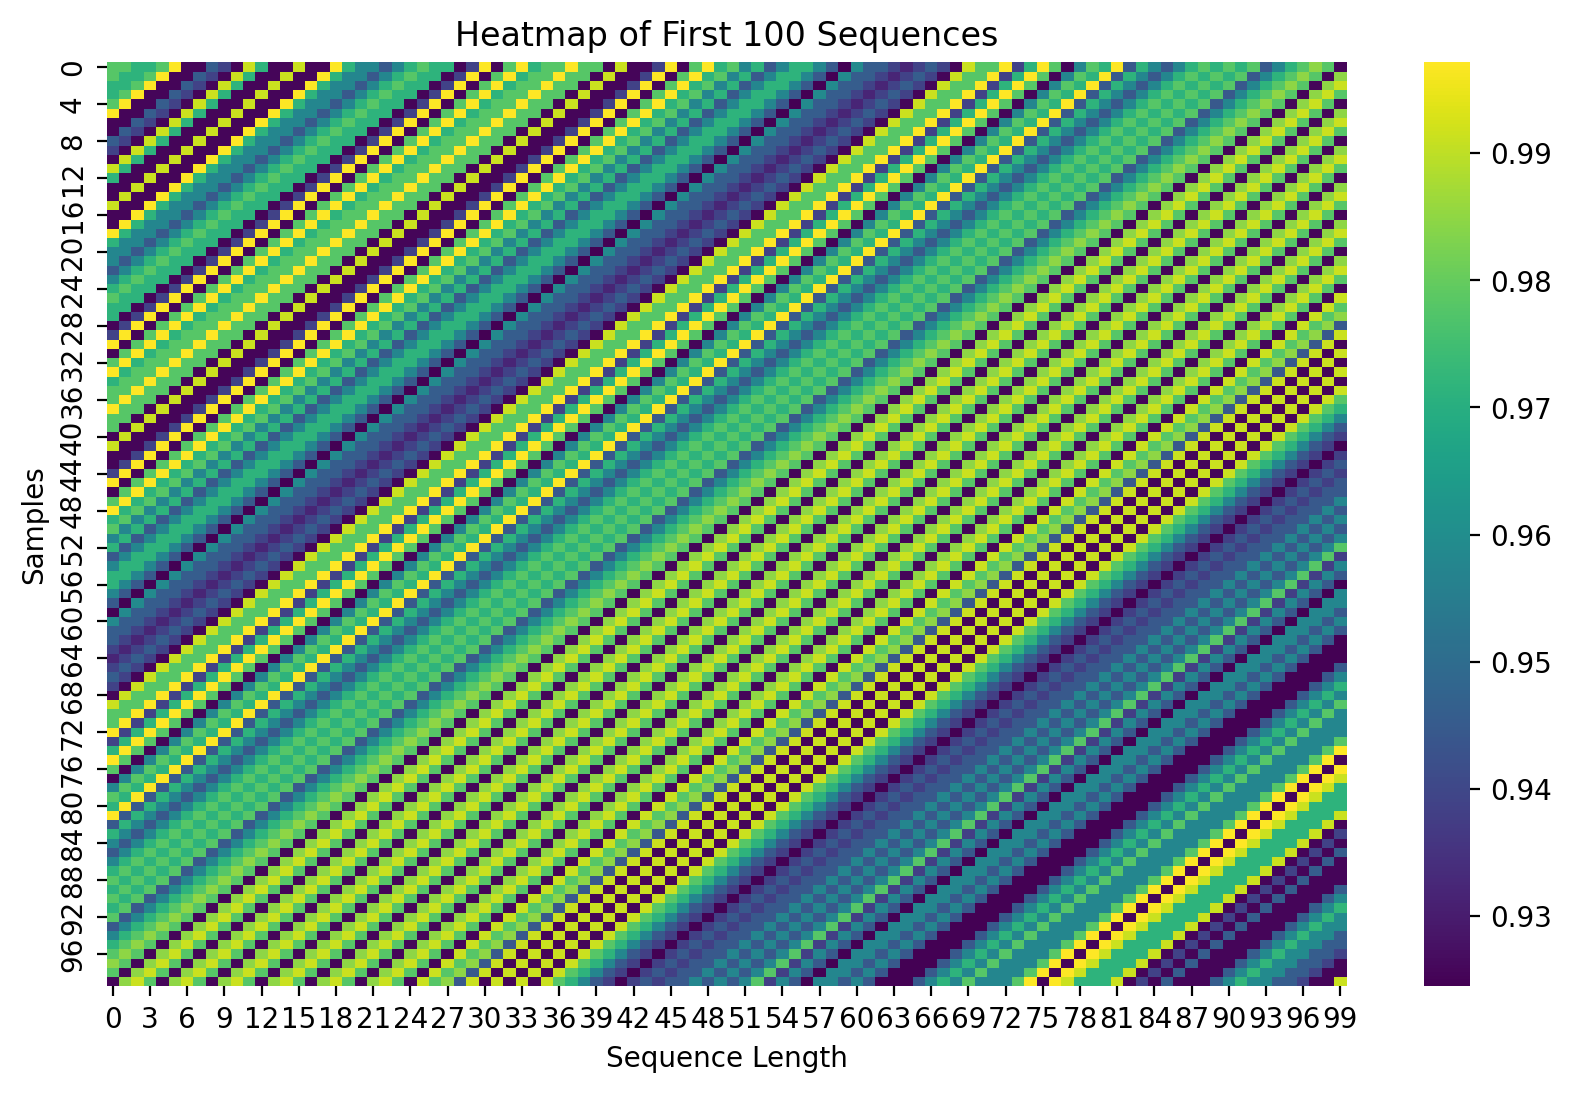

In [26]:
# Plot a heatmap of the first few sequences
def plot_heatmap_sequences(sequences, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(sequences, cmap='viridis')
    plt.title(title)
    plt.xlabel('Sequence Length')
    plt.ylabel('Samples')
    plt.show()


# Plot heatmap of the first few sequences (for example, first 100 sequences)
plot_heatmap_sequences(network_input[:100].reshape(100, sequence_length), 'Heatmap of First 100 Sequences')


The graph visually represents the note pitch values across the first 100 sequences in the dataset. The x-axis denotes the sequence length, with values ranging from 0 to 99, corresponding to the time steps in each sequence. The y-axis represents the sample index, with values ranging from 0 to 99, indicating the individual sequences. The heatmap employs a color gradient from purple to yellow, where the color intensity represents the normalized note pitch values. Lighter colors indicate higher pitch values, while darker colors represent lower pitch values. This visualization allows for the observation of patterns and trends within the sequences. The distinct diagonal patterns in the heatmap indicate strong temporal dependencies and consistent pitch transitions, which suggest that using models capable of capturing sequential data, such as recurrent neural networks (RNNs) or long short-term memory (LSTM) networks, would be effective in learning and predicting musical sequences.


# Model architecture and training

In [12]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

input_shape = (sequence_length, 1)
num_classes = len(set(labels))
model = create_cnn_model(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# Save the model
model.save('composer_cnn_model.h5')


Epoch 1/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.5129 - loss: 1.1249 - val_accuracy: 0.5973 - val_loss: 0.9597
Epoch 2/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.6128 - loss: 0.9220 - val_accuracy: 0.6517 - val_loss: 0.8321
Epoch 3/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.6919 - loss: 0.7458 - val_accuracy: 0.7140 - val_loss: 0.6987
Epoch 4/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.7501 - loss: 0.6134 - val_accuracy: 0.7451 - val_loss: 0.6344
Epoch 5/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.7952 - loss: 0.5074 - val_accuracy: 0.7736 - val_loss: 0.5609
Epoch 6/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.8245 - loss: 0.4344 - val_accuracy: 0.7962 - val_loss: 0.5149
Epoch 7/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.8494 - loss: 0.3720 - val_accuracy: 0.7926 - val_loss: 0.5027
Epoch 8/50
6071/6071 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.8641 - loss: 0

# Model evaluation

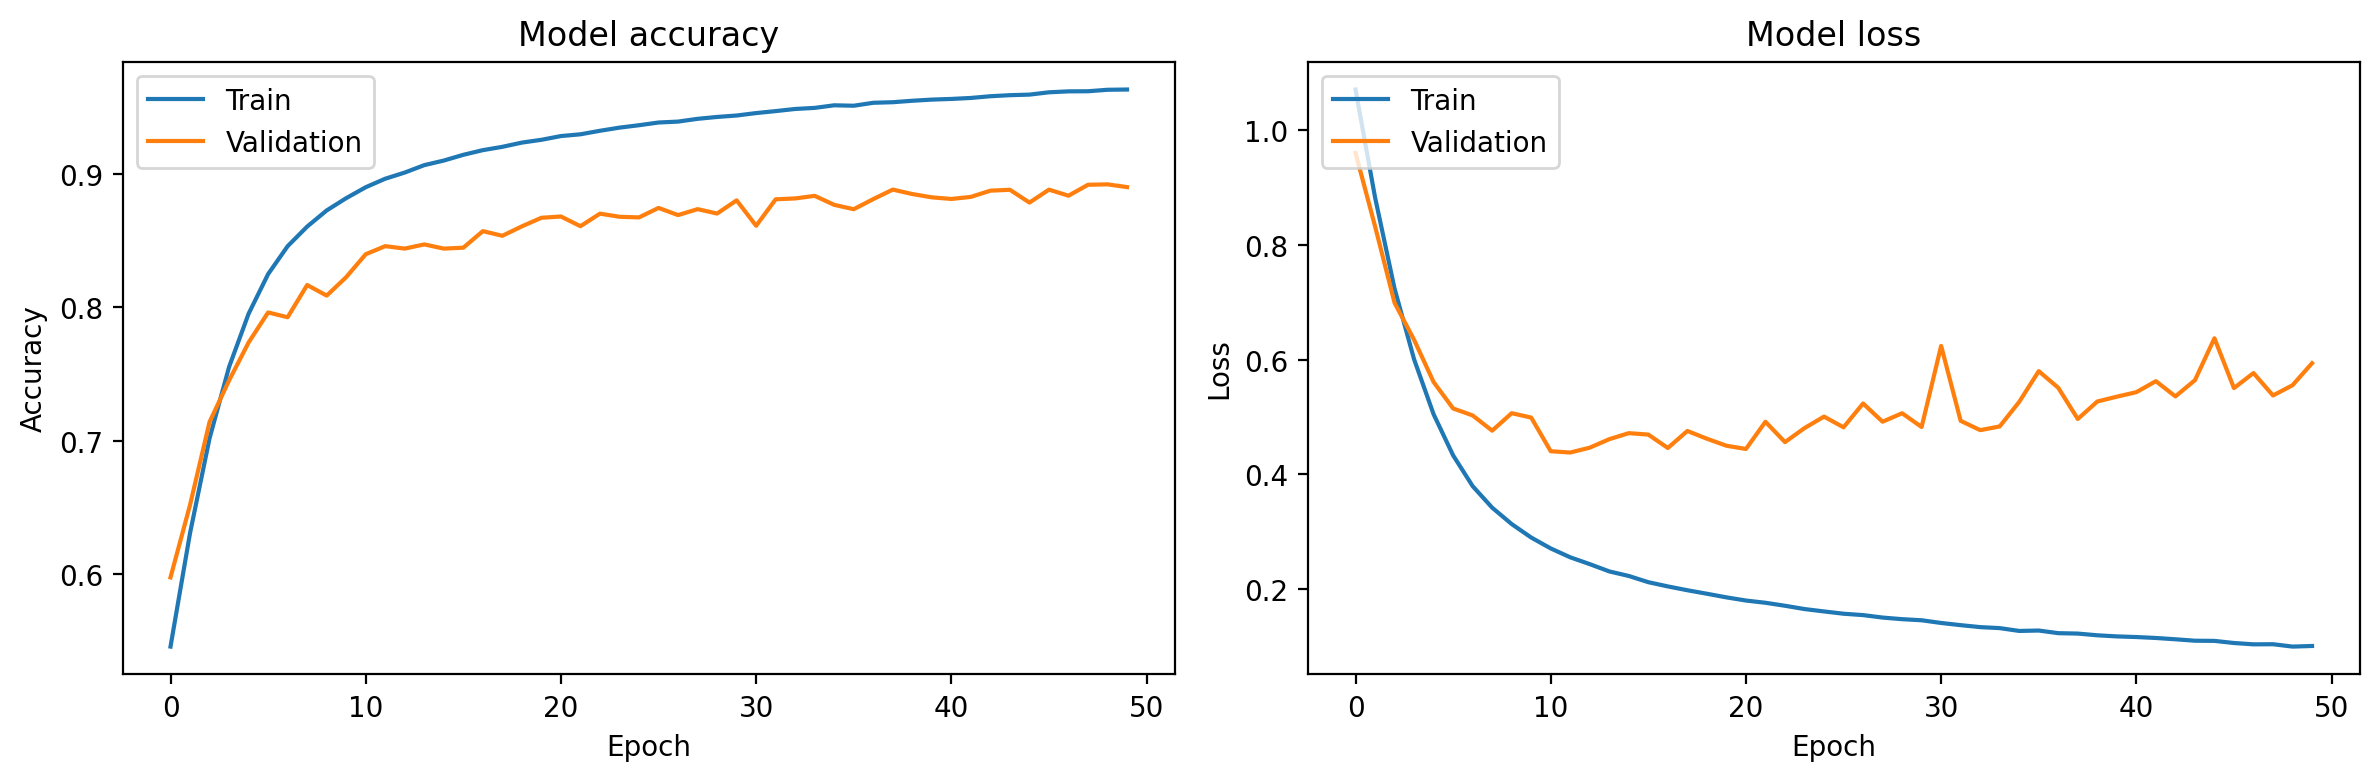

In [13]:
# Evaluate the model
def evaluate_model(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

evaluate_model(history)


# Confusion matrix and classification report

3036/3036 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


<Figure size 1000x1000 with 0 Axes>

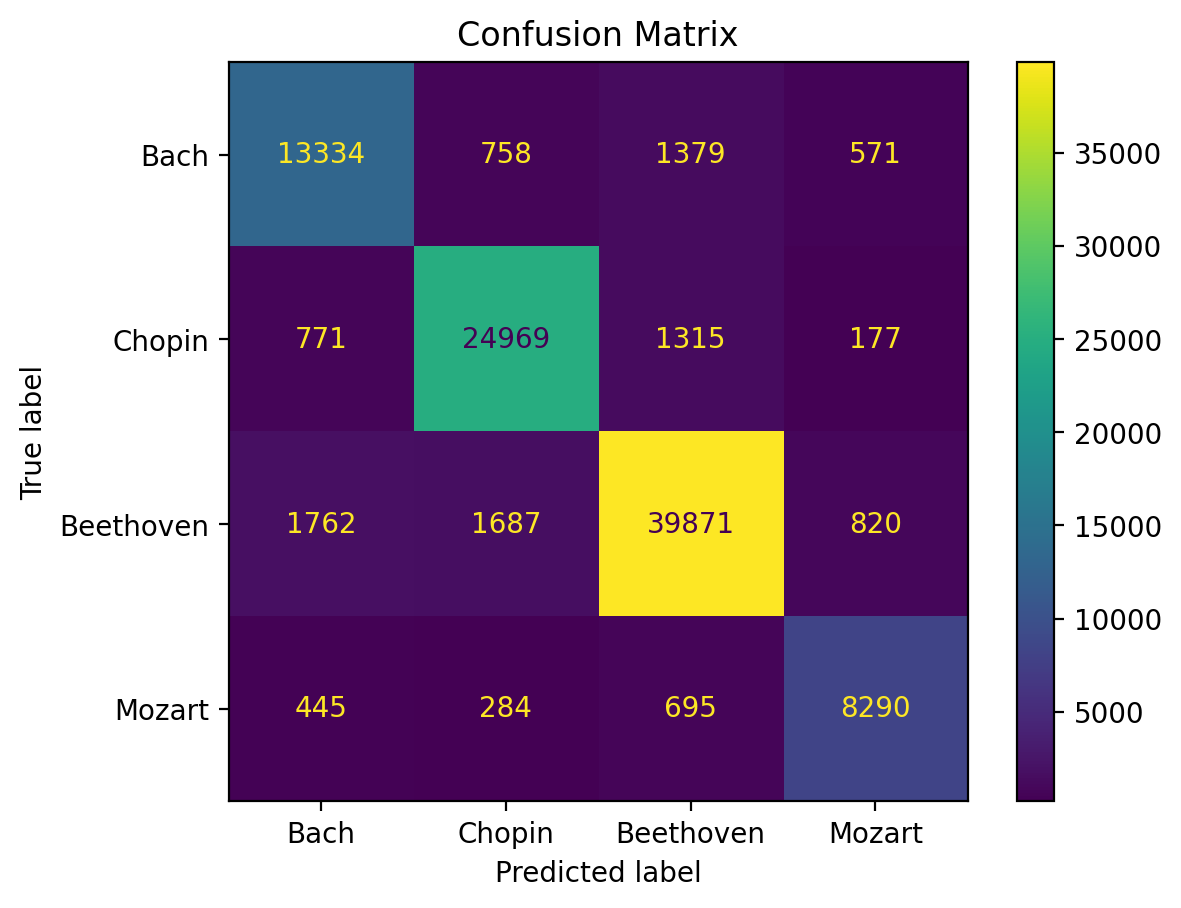

              precision    recall  f1-score   support

        Bach       0.82      0.83      0.82     16042
      Chopin       0.90      0.92      0.91     27232
   Beethoven       0.92      0.90      0.91     44140
      Mozart       0.84      0.85      0.85      9714

    accuracy                           0.89     97128
   macro avg       0.87      0.88      0.87     97128
weighted avg       0.89      0.89      0.89     97128



In [20]:
# Plot confusion matrix and print classification report
def plot_confusion_matrix_and_classification_report(model, X_val, y_val, label_list):
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(label_list)))
    
    plt.figure(figsize=(10, 10))
    cm_display.plot(cmap='viridis', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    report = classification_report(y_true, y_pred_classes, target_names=list(set(label_list)))
    print(report)

plot_confusion_matrix_and_classification_report(model, X_val, y_val, label_list)
